**# 1. INSTALASI DAN IMPORT LIBRARY**

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

print("Semua library berhasil diimport!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Semua library berhasil diimport!


**2. PERSIAPAN DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DataSet/email.csv")
print("Dataset berhasil dimuat. Dimensi dataset:", data.shape)
print(data.head())

Dataset berhasil dimuat. Dimensi dataset: (5573, 2)
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


**3. ANALISIS EKSPLORATORI DATA bold text bold text**

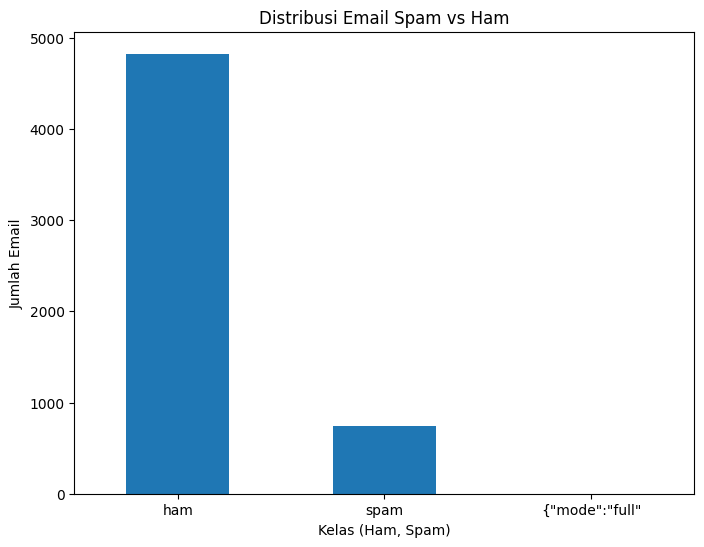


Statistik Dataset:
Total email: 5573
Email spam: 747 (13.4%)
Email ham: 4825 (86.6%)


In [ ]:
# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
data['Category'].value_counts().plot(kind='bar')
plt.title('Distribusi Email Spam vs Ham')
plt.xlabel('Kelas (Ham, Spam)')
plt.ylabel('Jumlah Email')
plt.xticks(rotation=0)
plt.show()

# Statistik dasar
print("\nStatistik Dataset:")
print(f"Total email: {len(data)}")
print(f"Email spam: {sum(data['Category'] == 'spam')} ({sum(data['Category'] == 'spam')/len(data)*100:.1f}%)")
print(f"Email ham: {sum(data['Category'] == 'ham')} ({sum(data['Category'] == 'ham')/len(data)*100:.1f}%)")

**# 4. PREPROCESSING DATA**

In [ ]:
# Bersihkan data yang tidak lengkap
df = data.dropna().copy() # Create a copy to avoid SettingWithCopyWarning
print(f"Dataset setelah cleaning: {len(df)} email")

# Fungsi untuk membersihkan teks
def clean_email_text(text):
    """
    Membersihkan teks email dari tanda baca dan stop words
    """
    # Konversi ke lowercase
    text = text.lower()

    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Hapus stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)



Dataset setelah cleaning: 5573 email


In [ ]:
# Terapkan preprocessing
print("Melakukan preprocessing teks...")
df['cleaned_email'] = df['Message'].apply(clean_email_text)

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(min(3, len(df))): # Ensure we don't go out of bounds
    print(f"Original: {df.iloc[i]['Message']}")
    print(f"Cleaned:  {df.iloc[i]['cleaned_email']}")
    print(f"Label:    {df.iloc[i]['Category']}")
    print("-" * 50)

# Map 'ham' to 0 and 'spam' to 1
df['class'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

Melakukan preprocessing teks...

Contoh hasil preprocessing:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned:  jurong point crazy available bugis great world buffet cine got amore wat
Label:    ham
--------------------------------------------------
Original: Ok lar... Joking wif u oni...
Cleaned:  lar joking wif oni
Label:    ham
--------------------------------------------------
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned:  free entry wkly comp win cup final tkts may text receive entry questionstd txt ratetcs apply overs
Label:    spam
--------------------------------------------------


**# 5. TOKENISASI DAN PADDING**

In [ ]:
# Parameter tokenisasi
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_email'])

# Konversi teks ke sequence
sequences = tokenizer.texts_to_sequences(df['cleaned_email'])

# Padding sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y = df['class'].values

print(f"Shape data setelah tokenisasi: {X.shape}")
print(f"Shape label: {y.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Shape data setelah tokenisasi: (5573, 100)
Shape label: (5573,)
Vocabulary size: 8293


**# 6. PEMBAGIAN DATA**

In [ ]:
def evaluate_model_with_test_size(X, y, MAX_WORDS, MAX_SEQUENCE_LENGTH, test_size_list=[0.2, 0.3, 0.4]):
    """
    Mengevaluasi model dengan berbagai ukuran test size
    """
    results = {}

    for test_size in test_size_list:
        print(f"\n{'='*50}")
        print(f"EVALUASI DENGAN TEST SIZE: {test_size}")
        print(f"{'='*50}")

        # Bagi data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        print(f"Data training: {X_train.shape[0]} sampel")
        print(f"Data testing: {X_test.shape[0]} sampel")

        # MEMBANGUN MODEL CNN
        print("\nMembangun model CNN...")
        model = Sequential([
            # Lapisan Embedding
            Embedding(input_dim=MAX_WORDS,
                     output_dim=128,
                     input_length=MAX_SEQUENCE_LENGTH),

            # Lapisan Konvolusi
            Conv1D(filters=64, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=2),

            Conv1D(filters=32, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),

            # Flatten dan Dense layers
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.3),

            # Output layer
            Dense(1, activation='sigmoid')
        ])

        # Kompilasi model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        print("\nArsitektur Model:")
        model.summary()

        # TRAINING MODEL
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.0001,
            verbose=1
        )

        # Training
        print(f"\nMemulai training model untuk test size {test_size}...")
        history = model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=20,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # EVALUASI MODEL
        print(f"\nMelakukan evaluasi model untuk test size {test_size}...")
        # Prediksi
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Hitung metrik
        accuracy = np.mean(y_pred == y_test)
        f1 = f1_score(y_test, y_pred)

        # Simpan hasil
        results[test_size] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'history': history,
            'y_test': y_test,
            'y_pred': y_pred,
            'model': model # Store the trained model for this test size
        }

        print(f"\nHasil untuk test size {test_size}:")
        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"F1-Score: {f1:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred,
                                  target_names=['Ham', 'Spam']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Ham', 'Spam'],
                   yticklabels=['Ham', 'Spam'])
        plt.title(f'Confusion Matrix (Test Size: {test_size})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Plot training history
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'Model Accuracy (Test Size: {test_size})')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'Model Loss (Test Size: {test_size})')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    return results # Return the results dictionary containing models and metrics for each test size


EVALUASI DENGAN TEST SIZE: 0.2
Data training: 4458 sampel
Data testing: 1115 sampel

Membangun model CNN...

Arsitektur Model:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai training model untuk test size 0.2...
Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8705 - loss: 0.3648 - val_accuracy: 0.9785 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9867 - loss: 0.0650 - val_accuracy: 0.9767 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9969 - loss: 0.0141 - val_accuracy: 0.9830 - val_loss: 0.1075 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.9812 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9978 - loss: 0.0052
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9978 - loss: 0.0052 - val_accuracy: 0.9740 - val_loss: 0.1560 - learning_rate: 0.0010
Epoch 6/20
140/140 ━━━━━━━━━━━━━

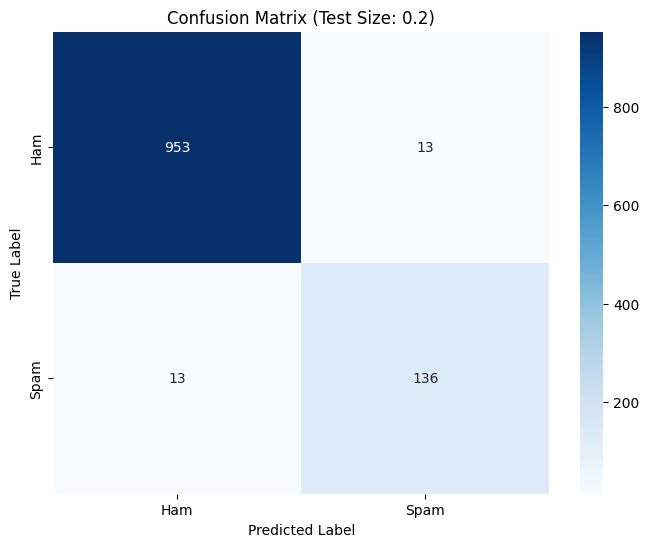

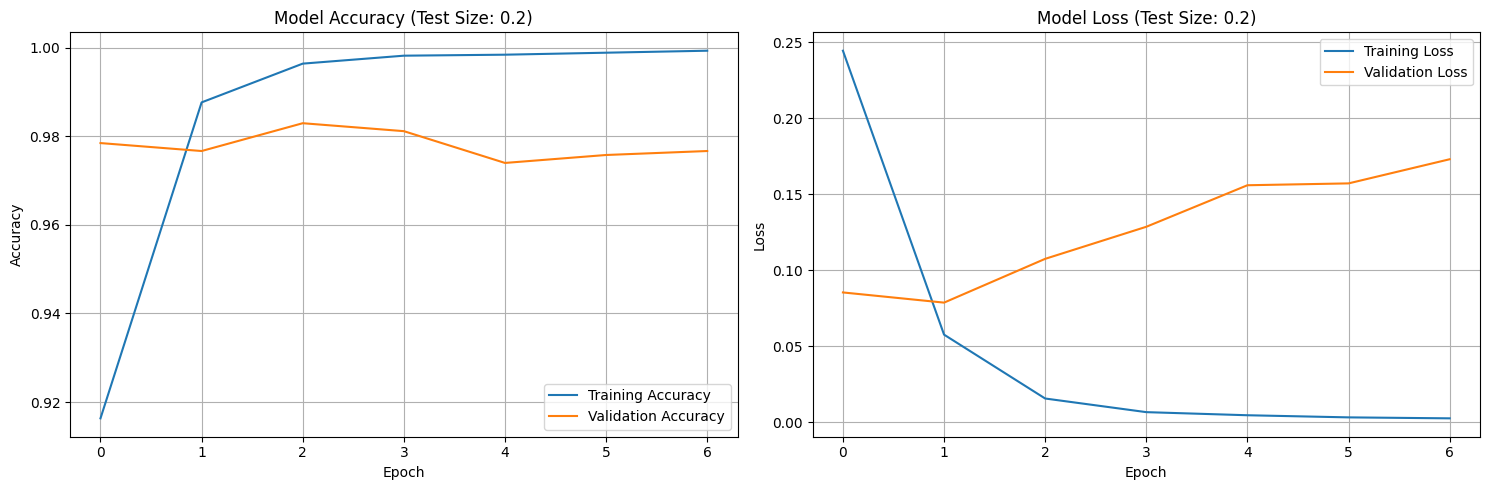


EVALUASI DENGAN TEST SIZE: 0.3
Data training: 3901 sampel
Data testing: 1672 sampel

Membangun model CNN...

Arsitektur Model:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai training model untuk test size 0.3...
Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8679 - loss: 0.3783 - val_accuracy: 0.9797 - val_loss: 0.0785 - learning_rate: 0.0010
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9887 - loss: 0.0517 - val_accuracy: 0.9809 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.9797 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9731 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 5/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9989 - loss: 0.0059
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.9839 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 6/20
122/122 ━━━━━━━━━━━━━━

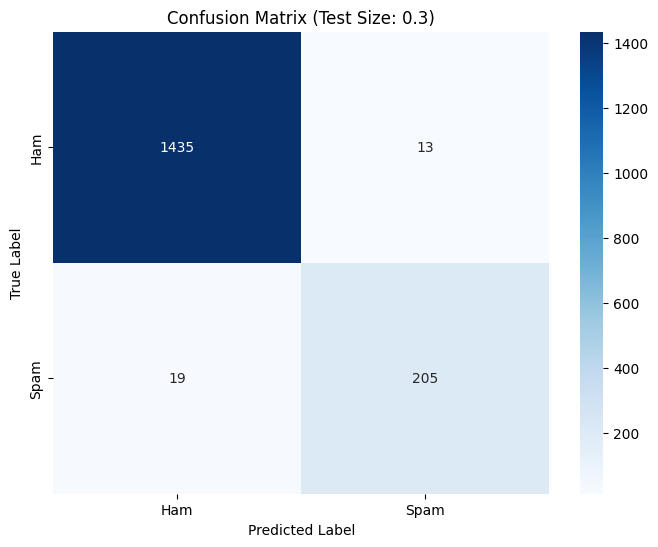

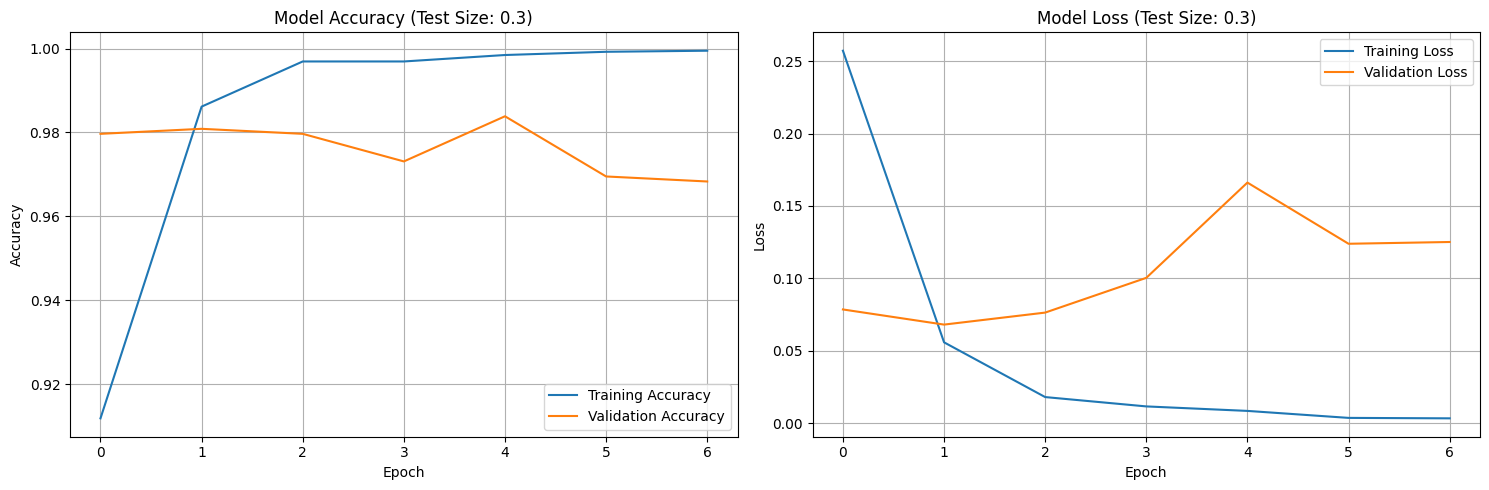


EVALUASI DENGAN TEST SIZE: 0.4
Data training: 3343 sampel
Data testing: 2230 sampel

Membangun model CNN...

Arsitektur Model:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai training model untuk test size 0.4...
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8372 - loss: 0.4410 - val_accuracy: 0.9614 - val_loss: 0.1113 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9784 - loss: 0.0750 - val_accuracy: 0.9762 - val_loss: 0.1349 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9950 - loss: 0.0291 - val_accuracy: 0.9785 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9776 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9988 - loss: 0.0054 - val_accuracy: 0.9767 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 6/20
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9987 - loss: 0.0086
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
105/105 ━━━━━━━━━━━━━━━

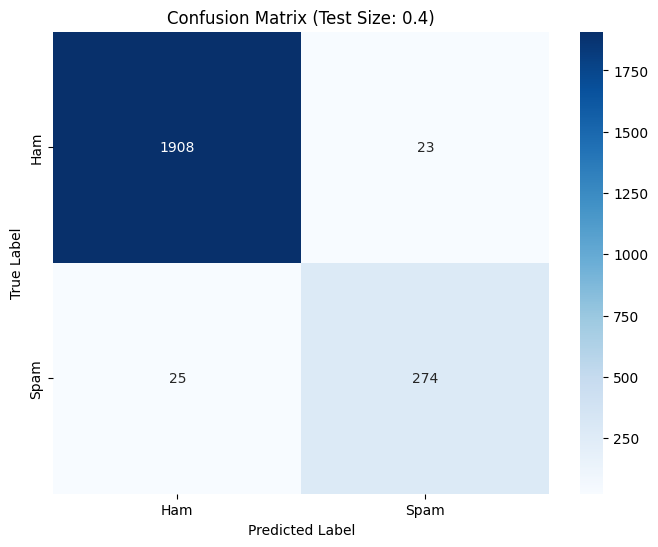

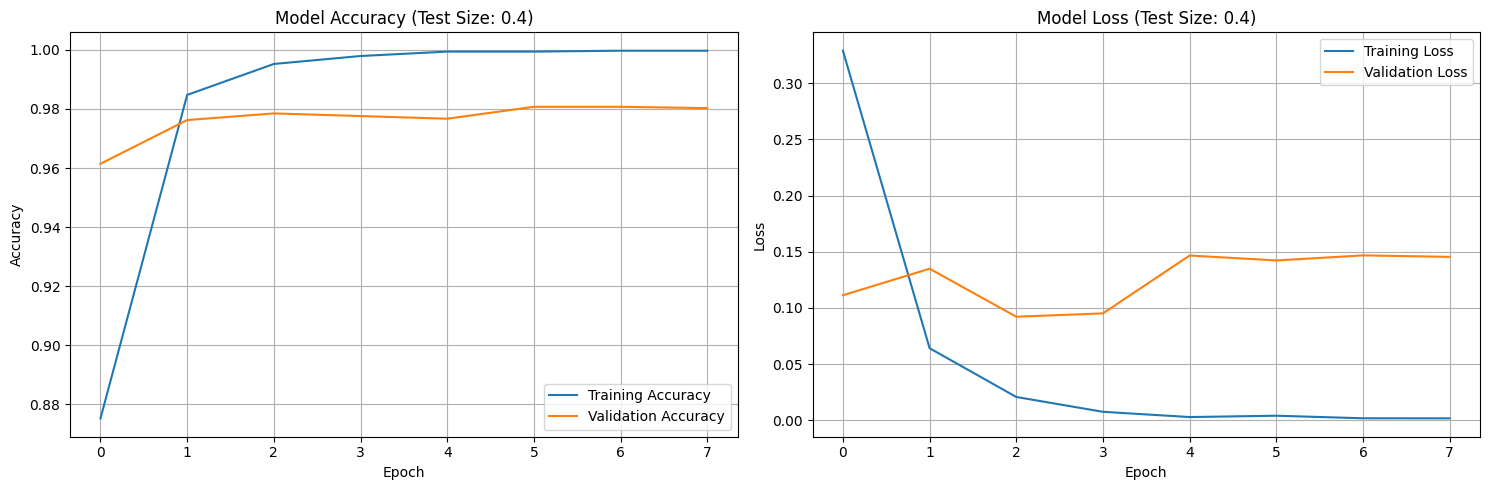

Value of results after function call: {0.2: {'accuracy': np.float64(0.9766816143497757), 'f1_score': 0.912751677852349, 'history': <keras.src.callbacks.history.History object at 0x7fa34a25ffd0>, 'y_test': array([0, 0, 0, ..., 0, 0, 1]), 'y_pred': array([0, 0, 0, ..., 0, 0, 1]), 'model': <Sequential name=sequential_16, built=True>}, 0.3: {'accuracy': np.float64(0.9808612440191388), 'f1_score': 0.9276018099547512, 'history': <keras.src.callbacks.history.History object at 0x7fa34aceea10>, 'y_test': array([1, 0, 0, ..., 0, 0, 0]), 'y_pred': array([1, 0, 0, ..., 0, 0, 0]), 'model': <Sequential name=sequential_17, built=True>}, 0.4: {'accuracy': np.float64(0.97847533632287), 'f1_score': 0.9194630872483222, 'history': <keras.src.callbacks.history.History object at 0x7fa34daef510>, 'y_test': array([0, 0, 0, ..., 0, 0, 0]), 'y_pred': array([0, 0, 0, ..., 0, 0, 0]), 'model': <Sequential name=sequential_18, built=True>}}

Model terbaik: Test Size 0.3
Akurasi: 0.9809
Model dan tokenizer berhasil d

In [ ]:
# Jalankan evaluasi dan dapatkan hasilnya
# Pass the necessary variables to the function
results = evaluate_model_with_test_size(X, y, MAX_WORDS, MAX_SEQUENCE_LENGTH)

# --- Debugging line ---
print(f"Value of results after function call: {results}")
# --- End Debugging line ---

# Pilih model dengan akurasi terbaik
# Find the test size with the highest accuracy
best_test_size = None
best_accuracy = -1

for ts, result in results.items():
    if result['accuracy'] > best_accuracy:
        best_accuracy = result['accuracy']
        best_test_size = ts

# Check if best_test_size was found
if best_test_size is not None:
    best_model = results[best_test_size]['model'] # Get the model corresponding to the best test size

    print(f"\nModel terbaik: Test Size {best_test_size}")
    print(f"Akurasi: {results[best_test_size]['accuracy']:.4f}")

    # Simpan model dan tokenizer
    try:
        # Ensure tokenizer is available in this scope
        # tokenizer should be available if previous cells were run
        best_model.save('spam_classifier_model.h5')
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model dan tokenizer berhasil disimpan!")
    except Exception as e:
        print(f"Gagal menyimpan model atau tokenizer: {e}")
else:
    print("\nTidak dapat menemukan model terbaik. Evaluasi mungkin gagal.")

**# 10. PERBANDINGAN HASIL**


RINGKASAN HASIL EVALUASI
 Test Size Accuracy Accuracy (%) F1-Score
       0.2   0.9767       97.67%   0.9128
       0.3   0.9809       98.09%   0.9276
       0.4   0.9785       97.85%   0.9195


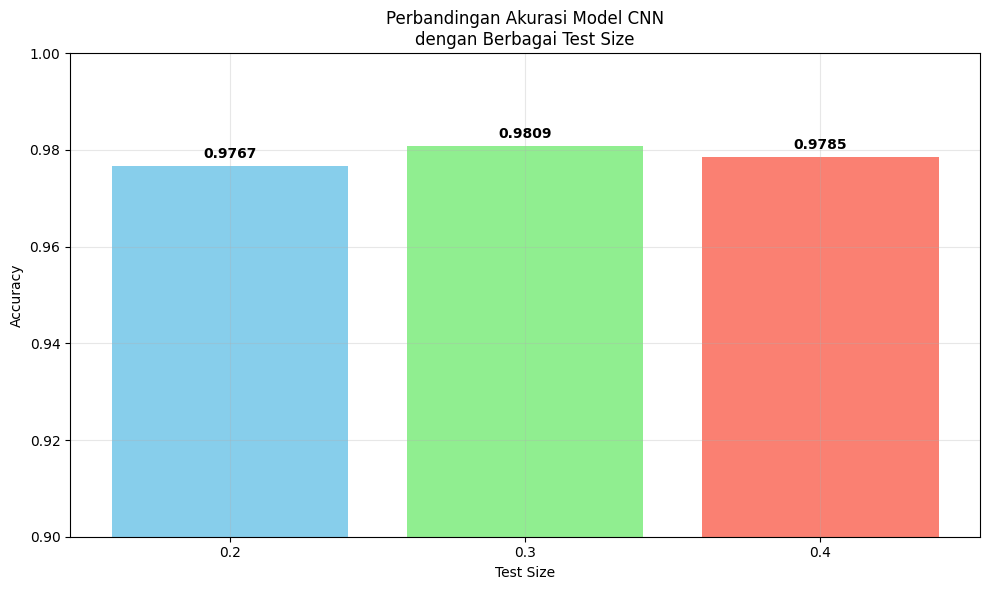

In [ ]:
print(f"\n{'='*60}")
print("RINGKASAN HASIL EVALUASI")
print(f"{'='*60}")

# Buat tabel perbandingan
comparison_data = []
for test_size, result in results.items():
    comparison_data.append({
        'Test Size': test_size,
        'Accuracy': f"{result['accuracy']:.4f}",
        'Accuracy (%)': f"{result['accuracy']*100:.2f}%",
        'F1-Score': f"{result['f1_score']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot perbandingan akurasi
test_sizes = list(results.keys())
accuracies = [results[ts]['accuracy'] for ts in test_sizes]

plt.figure(figsize=(10, 6))
bars = plt.bar([str(ts) for ts in test_sizes], accuracies,
               color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Perbandingan Akurasi Model CNN\ndengan Berbagai Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)

# Tambahkan nilai di atas bar
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**# 11. SIMPAN MODEL TERBAIK**

In [ ]:
# Pilih model dengan akurasi terbaik
# Find the test size with the highest accuracy
best_test_size = None
best_accuracy = -1

for ts, result in results.items():
    if result['accuracy'] > best_accuracy:
        best_accuracy = result['accuracy']
        best_test_size = ts

best_model = results[best_test_size]['model'] # Get the model corresponding to the best test size

print(f"\nModel terbaik: Test Size {best_test_size}")
print(f"Akurasi: {results[best_test_size]['accuracy']:.4f}")

# Simpan model dan tokenizer
best_model.save('spam_classifier_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model dan tokenizer berhasil disimpan!")


Model terbaik: Test Size 0.3
Akurasi: 0.9809
Model dan tokenizer berhasil disimpan!


**# 12. FUNGSI PREDIKSI UNTUK EMAIL BARU**

In [ ]:
def predict_email(email_text, model, tokenizer):
    """
    Memprediksi apakah email adalah spam atau ham
    """
    # Preprocessing
    cleaned_text = clean_email_text(email_text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    # Prediksi
    prediction = model.predict(padded_sequence)[0][0]

    return {
        'probability': float(prediction),
        'classification': 'Spam' if prediction > 0.5 else 'Ham',
        'confidence': float(abs(prediction - 0.5) * 2)
    }

**# 13. UJI COBA PREDIKSI**

In [ ]:
  ~      print(f"\n{'='*50}")
print("UJI COBA PREDIKSI EMAIL BARU")
print(f"{'='*50}")

# Contoh email untuk diuji
test_emails = [
    "Congratulations! You have won $10,000! Click here to claim now!",
    "Hi, let's schedule a meeting for tomorrow at 2 PM.",
    "FREE MONEY! Get rich quick scheme! Limited time offer!",
    "Your order confirmation #12345 has been processed successfully.",
    "URGENT: Your account will be suspended! Act now!",
    "The quarterly report is ready for your review."
]

for i, email in enumerate(test_emails, 1):
    result = predict_email(email, best_model, tokenizer)
    print(f"\nEmail {i}:")
    print(f"Text: {email}")
    print(f"Prediction: {result['classification']}")
    print(f"Probability: {result['probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("-" * 50)


UJI COBA PREDIKSI EMAIL BARU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Email 1:
Text: Congratulations! You have won $10,000! Click here to claim now!
Prediction: Ham
Probability: 0.4859
Confidence: 0.0282
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Email 2:
Text: Hi, let's schedule a meeting for tomorrow at 2 PM.
Prediction: Ham
Probability: 0.0013
Confidence: 0.9975
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Email 3:
Text: FREE MONEY! Get rich quick scheme! Limited time offer!
Prediction: Ham
Probability: 0.0024
Confidence: 0.9952
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Email 4:
Text: Your order confirmation #12345 has been processed successfully.
Prediction: Ham
Probability: 0.0655
Confidence: 0.8690
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Email 5:
Text: URGENT: Your account will be suspended! Ac